In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import numpy as np
from matplotlib.gridspec import GridSpecFromSubplotSpec, GridSpec
from tqdm.notebook import tqdm

import yaml
import sys
sys.path.append('../')
from hgpflow_v2.utility.helper_dicts import pdgid_class_dict

## Load data

In [2]:
file_path = 'path to seg file.root'

f = uproot.open(file_path)
tree = f['EventTree']

In [3]:
particle_pt    = tree['particle_pt'].array(library='np')
particle_eta   = tree['particle_eta'].array(library='np')
particle_phi   = tree['particle_phi'].array(library='np')
particle_e     = tree['particle_e'].array(library='np')
particle_pdgid = tree['particle_pdgid'].array(library='np')

In [4]:
topo_eta = tree['topo_eta'].array(library='np')
topo_phi = tree['topo_phi'].array(library='np')
topo_e   = tree['topo_e'].array(library='np')

In [5]:
topo2particle_topo_idxs     = tree['topo2particle_topo_idx'].array(library='np')
topo2particle_particle_idxs = tree['topo2particle_particle_idx'].array(library='np')
topo2particle_energies      = tree['topo2particle_energy'].array(library='np')

In [6]:
### get the deposited energy per particle and per topo
topo_dep_energy = []
particle_dep_energy = []

for ev, (topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_energy) in tqdm(enumerate(zip(topo2particle_topo_idxs, topo2particle_particle_idxs, topo2particle_energies)), total=len(topo2particle_topo_idxs)):
    topo_dep_energy_ev = np.zeros_like(topo_e[ev])
    particle_dep_energy_ev = np.zeros_like(particle_e[ev])

    for hit_idx, (topo_idx, particle_idx, energy) in enumerate(zip(topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_energy)):
        topo_dep_energy_ev[topo_idx] += energy
        particle_dep_energy_ev[particle_idx] += energy

    topo_dep_energy.append(topo_dep_energy_ev)
    particle_dep_energy.append(particle_dep_energy_ev)

topo_dep_energy = np.array(topo_dep_energy, dtype=object)
particle_dep_energy = np.array(particle_dep_energy, dtype=object)

  0%|          | 0/35799 [00:00<?, ?it/s]

In [7]:
### make some useful arrays in the same shape as "topo2particle" arrays
topo2particle_topo_energies = np.array([topo_e[ev][topo_idx] for ev, topo_idx in enumerate(topo2particle_topo_idxs)], dtype=object)
topo2particle_particle_energies = np.array([particle_e[ev][particle_idx] for ev, particle_idx in enumerate(topo2particle_particle_idxs)], dtype=object)
topo2particle_particle_pts = np.array([particle_pt[ev][particle_idx] for ev, particle_idx in enumerate(topo2particle_particle_idxs)], dtype=object)
topo2particle_particle_pdgids = np.array([particle_pdgid[ev][particle_idx] for ev, particle_idx in enumerate(topo2particle_particle_idxs)], dtype=object)
topo2particle_topo_dep_energies = np.array([topo_dep_energy[ev][topo_idx] for ev, topo_idx in enumerate(topo2particle_topo_idxs)], dtype=object)
topo2particle_particle_dep_energies = np.array([particle_dep_energy[ev][particle_idx] for ev, particle_idx in enumerate(topo2particle_particle_idxs)], dtype=object)
topo2particle_energies_over_topo_dep_energy = np.array([hit_energy/topo_dep_energy for hit_energy, topo_dep_energy in zip(topo2particle_energies, topo2particle_topo_dep_energies)], dtype=object)
topo2particle_energies_over_particle_dep_energy = np.array([hit_energy/particle_dep_energy for hit_energy, particle_dep_energy in zip(topo2particle_energies, topo2particle_particle_dep_energies)], dtype=object)

In [8]:
### find out whether a given hit is the leading one for its topo or for its particle
topo2particle_hit_is_leading_for_topo = []
topo2particle_hit_is_leading_for_particle = []

for ev, (topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_energy) in tqdm(enumerate(zip(topo2particle_topo_idxs, topo2particle_particle_idxs, topo2particle_energies)), total=len(topo2particle_topo_idxs)):
    topo2particle_hit_is_leading_for_topo_ev = np.zeros_like(topo2particle_topo_idx)
    topo2particle_hit_is_leading_for_particle_ev = np.zeros_like(topo2particle_particle_idx)

    for unique_topo_idx in np.unique(topo2particle_topo_idx):
        this_topo_mask = topo2particle_topo_idx == unique_topo_idx
        masked_energies = topo2particle_energy[this_topo_mask]
        the_max = masked_energies.max()
        the_sum = masked_energies.sum()
        topo2particle_hit_is_leading_for_topo_ev[this_topo_mask] = masked_energies == the_max

    for unique_particle_idx in np.unique(topo2particle_particle_idx):
        this_particle_mask = topo2particle_particle_idx == unique_particle_idx
        masked_energies = topo2particle_energy[this_particle_mask]
        the_max = masked_energies.max()
        the_sum = masked_energies.sum()
        topo2particle_hit_is_leading_for_particle_ev[this_particle_mask] = masked_energies == the_max

    topo2particle_hit_is_leading_for_topo.append(topo2particle_hit_is_leading_for_topo_ev.astype(bool))
    topo2particle_hit_is_leading_for_particle.append(topo2particle_hit_is_leading_for_particle_ev.astype(bool))

topo2particle_hit_is_leading_topo = np.array(topo2particle_hit_is_leading_for_topo, dtype=object)
topo2particle_hit_is_leading_particle = np.array(topo2particle_hit_is_leading_for_particle, dtype=object)

  0%|          | 0/35799 [00:00<?, ?it/s]

In [9]:
### associate an array of hits with each particle and each topo which are the fractions of the hit energy over the total deposited energy
topo_fractional_hits = []
particle_fractional_hits = []

for ev, (topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_energy) in tqdm(enumerate(zip(topo2particle_topo_idxs, topo2particle_particle_idxs, topo2particle_energies)), total=len(topo2particle_topo_idxs)):

    topo_fractional_hits_ev = []
    particle_fractional_hits_ev = []

    for topo_idx in range(len(topo_e[ev])):
        topo_mask = topo2particle_topo_idx == topo_idx
        hit_energies = topo2particle_energy[topo_mask]
        topo_fractional_hits_ev.append(hit_energies/topo_dep_energy[ev][topo_idx])

    for particle_idx in range(len(particle_e[ev])):
        particle_mask = topo2particle_particle_idx == particle_idx
        hit_energies = topo2particle_energy[particle_mask]
        particle_fractional_hits_ev.append(hit_energies/particle_dep_energy[ev][particle_idx])

    topo_fractional_hits.append(np.array(topo_fractional_hits_ev, dtype=object))
    particle_fractional_hits.append(np.array(particle_fractional_hits_ev, dtype=object))

topo_fractional_hits = np.array(topo_fractional_hits, dtype=object)
particle_fractional_hits = np.array(particle_fractional_hits, dtype=object)

  0%|          | 0/35799 [00:00<?, ?it/s]

# 2D plot

In [10]:
x = np.hstack(topo2particle_energies_over_particle_dep_energy)
y = np.hstack(topo2particle_energies_over_topo_dep_energy)

mask = np.ones_like(x, dtype=bool)

### hit must be at least 20% of the energy of the particle
# mask = mask & ((np.hstack(topo2particle_energies) / np.hstack(topo2particle_particle_energies)) > 0.2)

### hit must be at least 20% of the energy of the topo
# mask = mask & (np.hstack(topo2particle_energies) / np.hstack(topo2particle_topo_energies) > 0.2)

### hit must be the leading hit for the particle
# mask = mask & np.hstack(topo2particle_hit_is_leading_for_particle)

### hit must not be from electromagnetic activity
mask = mask & (np.hstack(topo2particle_particle_pdgids) != 22) & (np.abs(np.hstack(topo2particle_particle_pdgids)) != 11)

### hit must have minimum amount of energy
mask = mask & (np.hstack(topo2particle_energies) > 0.1)

x = x[mask]
y = y[mask]
w = np.ones_like(np.hstack(topo2particle_energies)[mask])

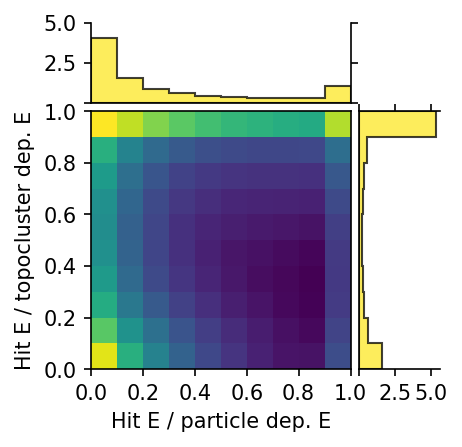

In [114]:
from matplotlib import gridspec
from matplotlib.colors import LogNorm

do_log = True

# Create figure and GridSpec layout
fig = plt.figure(figsize=(3, 3), dpi=150)
gs = gridspec.GridSpec(4, 4)

x_bins = np.linspace(0., 1., 11)
y_bins = np.linspace(0., 1., 11)
marginal_line_color = plt.cm.viridis(np.linspace(0, 1, 6))[-1]

# Main 2D density plot
ax_main = fig.add_subplot(gs[1:4, 0:3])

# Marginal distribution for x (top)
ax_xhist = fig.add_subplot(gs[0, 0:3], sharex=ax_main)

# Marginal distribution for y (right)
ax_yhist = fig.add_subplot(gs[1:4, 3], sharey=ax_main)

# Plot the 2D histogram (density plot) in the main panel
# hb = ax_main.hexbin(x, y, gridsize=50, cmap='Blues')
hb = ax_main.hist2d(x, y, bins=(x_bins, y_bins), cmap='viridis', density=True, weights=w, norm=LogNorm() if do_log else None)

# Add color bar
# cb = fig.colorbar(hb, ax=ax_main)
# cb.set_label('Counts')

# Plot marginal histograms
ax_xhist.hist(x, bins=x_bins, color=marginal_line_color, density=True, histtype='stepfilled', weights=w, edgecolor='black', alpha=0.75)
ax_yhist.hist(y, bins=y_bins, orientation='horizontal', color=marginal_line_color, density=True, histtype='stepfilled', weights=w, edgecolor='black', alpha=0.75)

# Hide x labels for the top plot and y labels for the right plot
plt.setp(ax_xhist.get_xticklabels(), visible=False)
plt.setp(ax_yhist.get_yticklabels(), visible=False)

# limits of the marginal histograms
ax_xhist.set_ylim(0., 5.)
ax_yhist.set_ylim(0., 5.)

# number of ticks on the marginal histograms
ax_xhist.yaxis.set_major_locator(FixedLocator(np.linspace(0., 5., 3)))
ax_yhist.xaxis.set_major_locator(FixedLocator(np.linspace(0., 5., 3)))

# Set log scale on marginal histograms
# if do_log:
#     ax_xhist.set_yscale('log')
#     ax_yhist.set_xscale('log')

# Set labels
ax_main.set_xlabel('Hit E / particle dep. E')
ax_main.set_ylabel('Hit E / topocluster dep. E')

# make sure the x and y axis of the main plot are the same
ax_main.set_xlim(0., 1.)
ax_main.set_ylim(0., 1.)
# also the ticks
ax_main.xaxis.set_major_locator(FixedLocator(np.linspace(0., 1., 6)))
ax_main.yaxis.set_major_locator(FixedLocator(np.linspace(0., 1., 6)))

# Adjust layout to remove gaps
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# remove the top and right lines on the outer axes
ax_xhist.spines['top'].set_visible(False)
ax_yhist.spines['right'].set_visible(False)

# make sure ticks are visible on the outer axes
ax_xhist.tick_params(axis='x', direction='in')
ax_yhist.tick_params(axis='y', direction='in')
ax_xhist.tick_params(bottom=False, top=False, left=True, right=True)
ax_xhist.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax_yhist.tick_params(bottom=True, top=True, left=False, right=False)
ax_yhist.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False)

# but make the first tick label invisible (keeping the tick)
ax_xhist.get_yticklabels()[0].set_visible(False)
ax_yhist.get_xticklabels()[0].set_visible(False)

# Show plot
plt.show()

In [115]:
fig.savefig('E_fraction_2D_distribution.png', dpi=300, bbox_inches='tight')

# Number of fractional hits

In [13]:
fractions = [0.0, 0.025, 0.05, 0.1, 0.2, 0.4, 1.0]
topo_n_hits_dict = {frac: [] for frac in fractions}
particle_n_hits_dict = {frac: [] for frac in fractions}

for i, frac in tqdm(enumerate(fractions[:-1]), total=len(fractions)-1):
    for topo_fractional_hits_ev in tqdm(topo_fractional_hits, total=len(topo_fractional_hits)):
        topo_n_hits_dict[frac].append(np.array([( (hits > frac) & (hits <= fractions[i+1]) ).sum() for hits in topo_fractional_hits_ev], dtype=int))

    for particle_fractional_hits_ev in tqdm(particle_fractional_hits, total=len(particle_fractional_hits)):
        particle_n_hits_dict[frac].append(np.array([( (hits > frac) & (hits <= fractions[i+1]) ).sum() for hits in particle_fractional_hits_ev], dtype=int))

    topo_n_hits_dict[frac] = np.array(topo_n_hits_dict[frac], dtype=object)

topo_n_hits_dict = {frac: np.array(topo_n_hits_dict[frac], dtype=object) for frac in fractions}
particle_n_hits_dict = {frac: np.array(particle_n_hits_dict[frac], dtype=object) for frac in fractions}

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

  0%|          | 0/35799 [00:00<?, ?it/s]

In [14]:
topo_n_hits_dict_flat = {frac: np.hstack(topo_n_hits_dict[frac].tolist()) for frac in fractions if frac != 1.0}
particle_n_hits_dict_flat = {frac: np.hstack(particle_n_hits_dict[frac].tolist()) for frac in fractions if frac != 1.0}

In [15]:
topo_n_hits_stacked = np.vstack([topo_n_hits_dict_flat[frac] for frac in fractions[::-1] if frac != 1.0]).T
particle_n_hits_stacked = np.vstack([particle_n_hits_dict_flat[frac] for frac in fractions[::-1] if frac != 1.0]).T

topo_n_hits_total = topo_n_hits_stacked.flatten()
particle_n_hits_total = particle_n_hits_stacked.flatten()

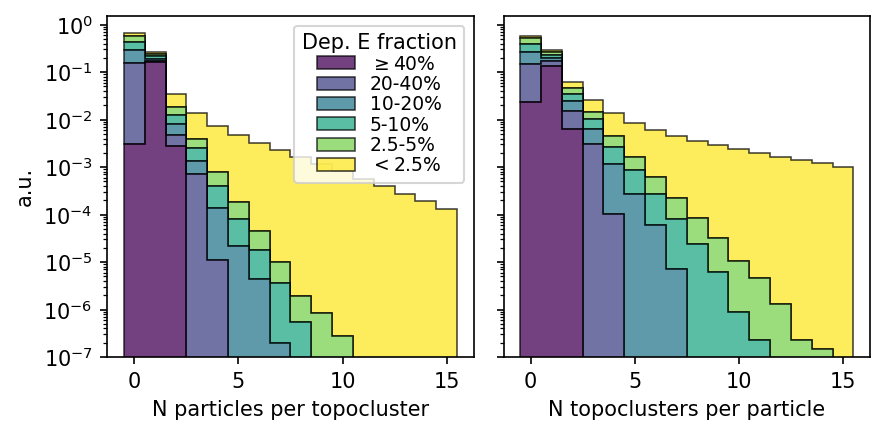

In [63]:
frac_bins = [f'{100*frac:.0f}-{100*frac2:.0f}%' for frac, frac2 in zip(fractions[:-1], fractions[1:])]
frac_bins[0] = r'$<$'     + f'{100*fractions[1]:.1f}%'
frac_bins[1] = f'{100*fractions[1]:.1f}-{100*fractions[2]:.0f}%'
frac_bins[-1] = r'$\geq$' + f'{100*fractions[-2]:.0f}%'

# stacked histograms of the number of hits per topo and per particle for different energy fractions

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharey=True)

N_max = 15
bin_width = 1
bins = np.linspace(-0.5, N_max + 0.5, (N_max + 2)) * bin_width
bins = bins[bins<=N_max+bin_width]

colors = plt.cm.viridis(np.linspace(0, 1, len(frac_bins)))

normalize = True
do_log = True

# ax[0].hist(topo_n_hits_total, bins=bins, label='Total', density=normalize, color='black', histtype='step')
ax[0].hist(topo_n_hits_stacked, bins=bins, stacked=True, label=frac_bins[::-1], density=normalize, color=colors, alpha=0.75, edgecolor='black', histtype='stepfilled',linewidth=0.75)
if normalize:
    ax[0].set_ylabel('a.u.')
else:
    ax[0].set_ylabel('N')
ax[0].set_xlabel('N particles per topocluster')

# ax[1].hist(particle_n_hits_total, bins=bins, label='Total', density=normalize, color='black', histtype='step')
ax[1].hist(particle_n_hits_stacked, bins=bins, stacked=True, label=frac_bins[::-1], density=normalize, color=colors, alpha=0.75, edgecolor='black', histtype='stepfilled',linewidth=0.75)
# ax[1].set_title('Particle')
ax[1].set_xlabel('N topoclusters per particle')

### legend to the right of the plot
# ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Energy fraction')
# ax[0].legend(loc='upper right', title='Dep. E fraction', ncol=2,  fontsize='small', title_fontsize='medium', labelspacing=0.05, columnspacing=0.2)

# legend with entries in reverse order
handles, labels = plt.gca().get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='upper right', title='Dep. E fraction', labelspacing=0.07, fontsize=9)

if do_log:
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    if normalize:
        ax[0].set_ylim(1e-7, 1.5e0)
    else:
        ax[0].set_ylim(0.5, 5e7)

plt.tight_layout()

plt.show()


In [64]:
fig.savefig('N_per_distributions.png', dpi=300, bbox_inches='tight')

# Incidence matrix

In [140]:
def plot_inc_matrix(topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_e, dual = False):

    num_particles = topo2particle_particle_idx.max() + 1
    num_topoclusters = topo2particle_topo_idx.max() + 1

    w = num_particles
    h = num_topoclusters

    fig = plt.figure(figsize=(3,3), dpi=150)

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')

    incidence_matrix = np.zeros((num_topoclusters, num_particles))

    for cluster_idx, part_idx, e in zip(topo2particle_topo_idx, topo2particle_particle_idx, topo2particle_e):
        incidence_matrix[cluster_idx, part_idx] = e

    if dual:
        incidence_matrix = incidence_matrix / incidence_matrix.sum(axis=0).reshape(1,-1)
    else:
        incidence_matrix = incidence_matrix / incidence_matrix.sum(axis=1).reshape(-1,1)
    # incidence_matrix = incidence_matrix != 0

    # plot the matrix in a grid
    im = ax.imshow(incidence_matrix, cmap='viridis_r', interpolation='none', aspect='auto')
    ax.set_xlabel('Particle')
    ax.set_ylabel('Topocluster')
    # make values below 0.01 white
    im.cmap.set_under('white')
    im.set_clim(0.01, 1)

    # add colorbar
    fig.colorbar(im, label = 'Topocluster dep. E fraction')

    tick_positions = np.arange(num_topoclusters + 2)-0.5
    ax.yaxis.set_minor_locator(FixedLocator(tick_positions))
    ax.grid(which='minor', color='k', linestyle='-', lw=0.1)

    tick_positions = np.arange(num_particles+2)-0.5
    ax.xaxis.set_minor_locator(FixedLocator(tick_positions))
    ax.grid(which='minor', color='k', linestyle='-', lw=0.1)
    ax.tick_params(which='minor', size=0)

    return fig, incidence_matrix

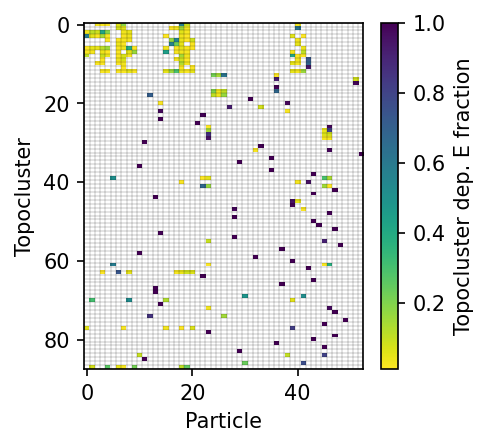

In [141]:
ev = 11
f, I = plot_inc_matrix(topo2particle_topo_idxs[ev], topo2particle_particle_idxs[ev], topo2particle_energies[ev])

In [142]:
# save the figure
f.savefig(f'incidence_matrix_ev{ev}.png', dpi=300, bbox_inches='tight')